In [1]:
from djccx.frd.readfrd import readfrd
from matplotlib import pyplot as plt
from validation.FullExperimental import FullExperimental
import os, glob
import numpy as np
from AnalyticalLayers.models import Tau_model
import pandas as pd


In [2]:
params = {
            "geo" : {
                        "t_n" : 2.934,
                        "t_l" : 0.475,
                        "Lx"  : 30,
                        "Ly"  : 25,
                        "meshsizefactor" : 1.2,
                    },
            "sim" : {
                        "disp" : 5.0,
                    },
            "tensile" : {
                        "disp" : 2.0,
                    },
        }



In [3]:
epsilon_tensile = params["tensile"]["disp"] / params["geo"]["Ly"]
eps_span = np.linspace(0, epsilon_tensile, 4)
print(eps_span)

[0.         0.02666667 0.05333333 0.08      ]


In [4]:
composition = [
        ["Y", "Y"],
        ["Y", "X"],
        ["Y", "SX"],
        ["Y", "SY"],
        ["Y", "SX" , "SY"],
        ["Y", "X"  , "SY"]
    ]
ni = [ len(c) for c in composition ]

In [5]:
tn = params["geo"]["t_n"]
tl = params["geo"]["t_l"]
Lx = params["geo"]["Lx"]

tt = [ Tau_model(tn,tl,ini) for ini in ni ]
tt = np.array(tt)
tt

array([4.834, 4.834, 4.834, 4.834, 5.784, 5.784])

In [6]:
df_exp = FullExperimental() 

In [7]:
df_exp.pop("Eb [GPa]")
df_exp.pop("Et [GPa]")
df_exp.pop("Vc")

Name
TFP1    0.178
TFP2    0.164
TFP3    0.135
TFP4    0.144
TFP5    0.146
TFP6    0.180
Name: Vc, dtype: float64

In [8]:
st_df_path = r"C:\Users\djoroya\Documents\GitHub\CITISENS_Composite_v2\scripts_finals\01_metodo\02_flexion\04_optim_stress\Sl.csv"
df_st = pd.read_csv(st_df_path)
df_st

,Unnamed: 0,0
0,S_fibra,651.843390
1,S_matrix,620.945570
2,S_X,473.050229
3,S_SX,195.889233
4,S_Y,266.080492
5,S_SY,93.029122


In [40]:
df_pred_path = r"C:\Users\djoroya\Documents\GitHub\CITISENS_Composite_v2\scripts_finals\01_metodo\02_flexion\04_optim_stress\df_pred.csv"

df_pred = pd.read_csv(df_pred_path)
df_pred

,Name,Et [GPa],Eb [GPa],St [MPa],Sb [MPa]
0,TFP1,9.178763,13.818303,111.044465,167.173511
1,TFP2,6.852442,9.260485,82.900688,139.435686
2,TFP3,6.509369,8.588324,78.750199,129.314905
3,TFP4,6.503316,8.576464,72.195440,95.210137
4,TFP5,6.816613,7.803995,75.673452,86.634698
5,TFP6,7.103338,8.196376,78.856476,90.990658


In [10]:
# St = np.array([254.673131,  # TFP1
#                164.532862,  # TFP2
#                137.191090,  # TFP3
#                117.631645,  # TFP4
#                109.185026,  # TFP5
#                117.132917	]) # TFP6

St = df_pred["Sb [MPa]"].values
St.tolist()

[167.1735112685771,
 139.43568643837844,
 129.3149047640252,
 95.2101371871304,
 86.63469791357055,
 90.9906576662027]

In [11]:

results = pd.read_csv("output.csv")

In [12]:
frds = glob.glob("output/*/sim/*.frd")
inps = glob.glob("output/*/sim/*.inp")


In [13]:
frds

['output\\TFP1\\sim\\main.frd',
 'output\\TFP2\\sim\\main.frd',
 'output\\TFP3\\sim\\main.frd',
 'output\\TFP4\\sim\\main.frd',
 'output\\TFP5\\sim\\main.frd',
 'output\\TFP6\\sim\\main.frd']

In [14]:
from djccx.inp.inp import inp

In [15]:

inp_f = inp(inps[0])
ifrd = readfrd(frds[0])

LAYERS =  inp_f.elements
nodes = LAYERS[0].GetUniqueNodes(inp_f.nodes)

zuniques = nodes["z"].unique()
# near mid
id_z = np.argmin(np.abs(zuniques - nodes["z"].mean()))
z = zuniques[id_z]

nodes = nodes[nodes["z"] == z]

nodes = inp_f.nodes
NSET_LOAD = inp_f.select("NSET_LOAD","nset")
nodes = NSET_LOAD.GetNodes(inp_f.nodes)


In [16]:
df_st.T

,0,1,2,3,4,5
Unnamed: 0,S_fibra,S_matrix,S_X,S_SX,S_Y,S_SY
0,651.84339,620.94557,473.050229,195.889233,266.080492,93.029122


In [17]:
St_layers = {
    "X"   : df_st.T[2].values[1],
    "SX"  : df_st.T[3].values[1],
    "Y"   : df_st.T[4].values[1],
    "SY"  : df_st.T[5].values[1],
    "nucleo" : 0.0,
}

# Predicciones del modelo analitico
Sb_TFP =  df_pred["Sb [MPa]"].values

In [18]:
from AnalyticalLayers.models import Tau_model

ni = [ len(c) for c in composition ]
tt = [ Tau_model(params["geo"]["t_n"],params["geo"]["t_l"],ini) for ini in ni ]

In [19]:
from scipy.interpolate import LinearNDInterpolator


In [20]:
 # interpo x,y,z,f

def PostProcessing(TPF):

    inp_f = inp(inps[TPF])
    ifrd = readfrd(frds[TPF])
    LAYERS =  inp_f.elements

    B = params["geo"]["Ly"]

    icomp = [ *composition[TPF][::-1] , "nucleo", *composition[TPF] ]

    print(icomp)

    rr = []
    L = 2*params["geo"]["Lx"]

    for data in ifrd["data_blocks"]:
        
        # ========================
        # Principal Stress
        # ========================
        P1s = []
        print("Time Step:")
        nodes_lines = []

        
        for idx in range(len(LAYERS)):
            nodes = LAYERS[idx].GetUniqueNodes(inp_f.nodes)

            zmin_to_eval = nodes["z"].min()

            x0 = 0
            y0 = B/2
            eps = 0.2

            nodes = nodes[nodes["x"] > x0 - eps]
            nodes = nodes[nodes["x"] < x0 + eps]
            nodes = nodes[nodes["y"] > y0 - eps]
            nodes = nodes[nodes["y"] < y0 + eps]
            
            zmax = nodes["z"].max()
            zmin = nodes["z"].min()
            zlen = zmax - zmin
            factor = 0.3
            zmin_new = zmin + factor*zlen
            zmax_new = zmax - factor*zlen

            nodes = nodes[nodes["z"] > zmin_new]
            nodes = nodes[nodes["z"] < zmax_new]
            # linear regression
            
            P1 = data.loc[nodes.index]["P1"]
            nodes["P1"] = P1

            # linear regression z vs P1
            z_reg  = nodes["z"]
            P1_reg = nodes["P1"]

            A = np.vstack([z_reg, np.ones(len(z_reg))]).T
            m, c = np.linalg.lstsq(A, P1_reg, rcond=None)[0]
            
            P1_reg = m*zmin_to_eval + c

            P1s.append(P1_reg)

            # x0 = 0, y0 = 0 
            nodes_line = nodes.copy()
            nodes_line = nodes[ nodes["x"] == 0 ]
            B   = 25
            eps = 0.5
            nodes_line = nodes_line[ nodes_line["y"] <= B/2 + eps ]
            nodes_line = nodes_line[ nodes_line["y"] >= B/2 - eps ]
            nodes_line["P1"] = data.loc[nodes_line.index]["P1"]
            nodes_lines.append(nodes_line)

        P1s = np.array(P1s)
        
        nodes = inp_f.nodes
        NSET_LOAD = inp_f.select("NSET_LOAD","nset")
        NSET_LOAD.GetNodes(inp_f.nodes)
        F3 = data.loc[NSET_LOAD.GetNodes(inp_f.nodes).index]["F3"]
        F3 = -2*np.sum(F3) # Symmetry of Model

        # force
        B = params["geo"]["Ly"]
        D = tt[TPF]
        L = 2*params["geo"]["Lx"]

        #
        # Medimos la fuerza en la mitad del modelo 
        # y calculamos la transformación a la fuerza que se aplican en los datos experimentales
        #
        sigma_exp = (3/2)*F3*L/(B*D**2)

        r = { 
            "layers"      : icomp       ,
            "P1"          : P1s         ,
            "F3"          : F3          , 
            "sigma_exp"   : sigma_exp   ,
            "nodes_lines" : nodes_lines ,
        }
        rr.append(r)

    
    ly = len(LAYERS)

    P1s =[]
    for i in range(ly):
        P1s.append([ r["P1"][i] for r in rr ])

    F3s = [ r["F3"] for r in rr ]
    S3s = [ r["sigma_exp"] for r in rr ]


    fig = plt.figure(figsize=(4,4))
    colors = ["r","g","b"]

    summary = {
        "layers" : icomp,
        "P1"     : np.array(P1s),
        "F3"     : np.array(F3s),
        "sigma_exp" : np.array(S3s),
    }
    for i,L in enumerate(P1s):
        if i>len(P1s)//2:
            break
        ly = rr[0]["layers"][i]
        St_layer = St_layers[ly]
        if ly != "nucleo":
            label = r"$\sigma_{max}^{"+ly + "} $ (FEM)"
            plt.plot(S3s,L,'.-',label=label,
                        color=colors[i])
            
            nSt = round(St_layer,1)
            label = r"$\sigma_{"+ly+"} = " + str(nSt) + r" \ MPa$ (analytical)"
            plt.axhline(St_layer,
                        linestyle="--",
                        color=colors[i],
                        label=label)
            
    plt.ylabel(r"$\sigma_{max}^{i}$ [MPa]",fontsize=12)
    plt.xlabel(r"$\sigma_{TFP" + str(TPF+1) + "}$ [MPa]",fontsize=12)
    #  Mpa vertical line
    # franja de error 10%
    ylim = plt.gca().get_ylim()
    plt.fill_betweenx([-100,1000],
                        Sb_TFP[TPF]*0.95,
                        Sb_TFP[TPF]*1.05,
                        alpha=0.2,
                        color="k",
                        label=r"$\sigma_{TPF"+str(TPF+1)+"} = " + str(Sb_TFP[TPF]) + r" \ MPa \pm 10 \%$")
    plt.ylim(ylim)
    # Lo cambiamos por una franja con error 10%
    plt.grid()
    # outside

    
    ly = len(LAYERS)
    P1s_end = [ P1[-1] for P1 in P1s ]
    P1s_end = np.array(P1s_end)
    P1s_end = P1s_end[ : ly%2 +1  ]

    alpha = P1s_end/S3s[-1]

    sigma_an =  [ St_layers[ly] for ly in icomp[:ly%2 +1 ] ]
    sigma_an = np.array(sigma_an)

    
    S3_pred = np.min(sigma_an/alpha)

    plt.axvline(S3_pred,linestyle="--",
                color="m",
                label=r"$\sigma_{pred} = " + str(round(S3_pred,1)) + r" \ MPa$")




    plt.title("TFP "+str(TPF+1) + " | Composition: " + str(icomp) )

    plt.legend( bbox_to_anchor=(1.05, 1), 
        loc='upper left', 
        borderaxespad=0.)
    
    print("factor",S3_pred/Sb_TFP[TPF])
    
    return rr, summary

In [21]:
summaries = []

['Y', 'Y', 'nucleo', 'Y', 'Y']
Time Step:
Time Step:
Time Step:
factor 1.0536496632549603


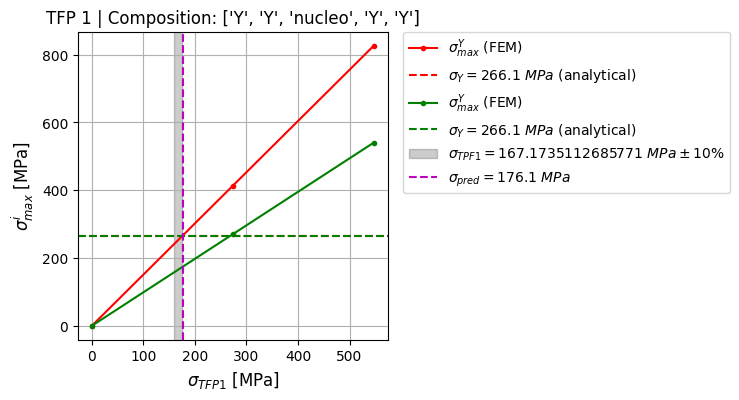

In [22]:
rr,summary = PostProcessing(0)

In [23]:
summaries.append(summary)

In [24]:
P1 = rr[0]["P1"]    

In [25]:
P1

array([0., 0., 0., 0., 0.])

(-200.0, 850.0)

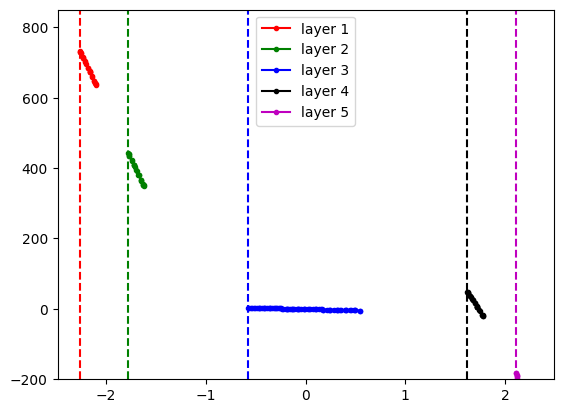

In [26]:
colors = ["r","g","b","k","m","c"]

for i,idf in enumerate(rr[-1]["nodes_lines"]):
    zline = idf["z"]
    zline = np.argsort(zline)
    idf = idf.iloc[zline]
    
    plt.plot(idf["z"],idf["P1"],'.-',label="layer "+str(i+1),color=colors[i])
    # 
    # 
    zmin = idf["z"].min()
    # vertical 
    plt.axvline(zmin,linestyle="--",color=colors[i])


plt.legend()
plt.ylim([-200,850])

['X', 'Y', 'nucleo', 'Y', 'X']
Time Step:
Time Step:
Time Step:
factor 1.225659779164195


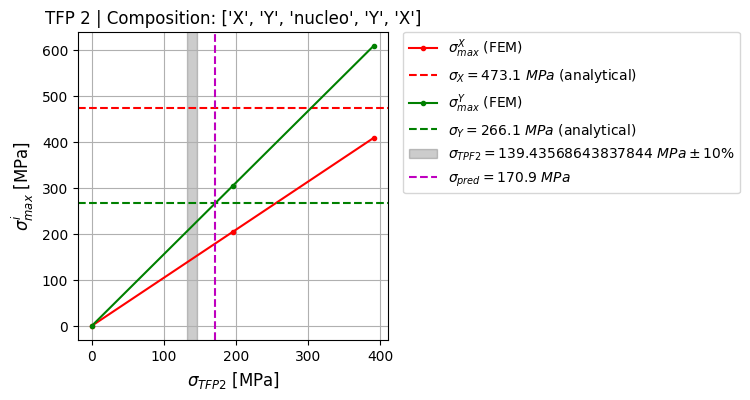

In [27]:
rr,summary = PostProcessing(1)
summaries.append(summary)

(-200.0, 850.0)

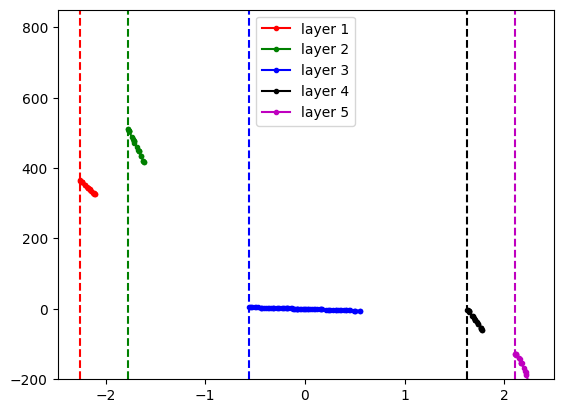

In [28]:
colors = ["r","g","b","k","m","c"]

for i,idf in enumerate(rr[-1]["nodes_lines"]):
    zline = idf["z"]
    zline = np.argsort(zline)
    idf = idf.iloc[zline]
    
    plt.plot(idf["z"],idf["P1"],'.-',label="layer "+str(i+1),color=colors[i])
    # 
    # 
    zmin = idf["z"].min()
    # vertical 
    plt.axvline(zmin,linestyle="--",color=colors[i])


plt.legend()
plt.ylim([-200,850])

['SX', 'Y', 'nucleo', 'Y', 'SX']
Time Step:
Time Step:
Time Step:
factor 1.2068287520747523


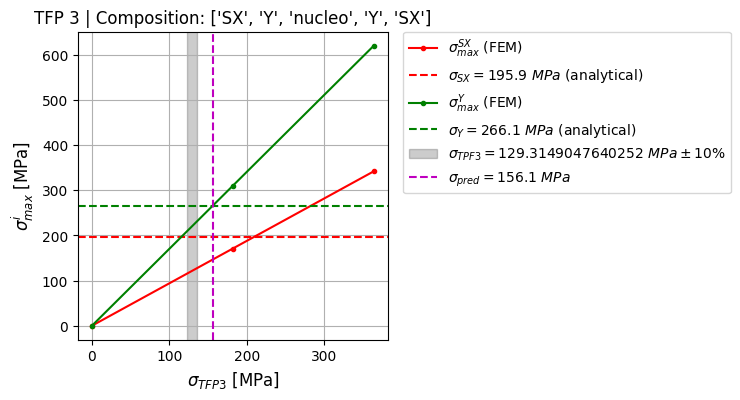

In [29]:
rr,summary = PostProcessing(2)
summaries.append(summary)

(-200.0, 850.0)

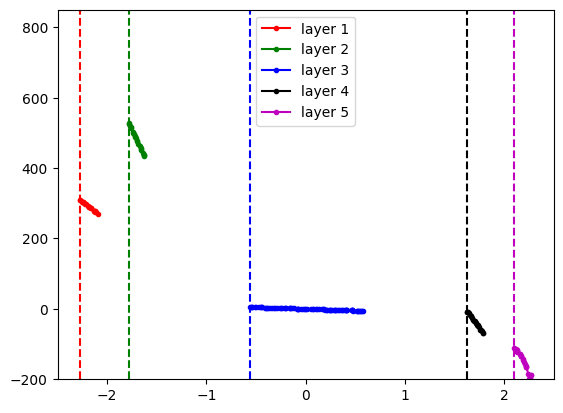

In [30]:
colors = ["r","g","b","k","m","c"]

for i,idf in enumerate(rr[-1]["nodes_lines"]):
    zline = idf["z"]
    zline = np.argsort(zline)
    idf = idf.iloc[zline]
    
    plt.plot(idf["z"],idf["P1"],'.-',label="layer "+str(i+1),color=colors[i])
    # 
    # 
    zmin = idf["z"].min()
    # vertical 
    plt.axvline(zmin,linestyle="--",color=colors[i])


plt.legend()
plt.ylim([-200,850])

['SY', 'Y', 'nucleo', 'Y', 'SY']
Time Step:
Time Step:
Time Step:
factor 1.0512586745693464


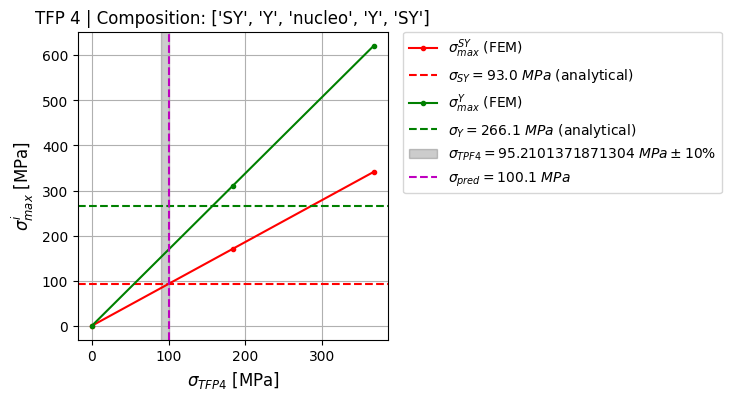

In [31]:
rr,summary = PostProcessing(3)
summaries.append(summary)

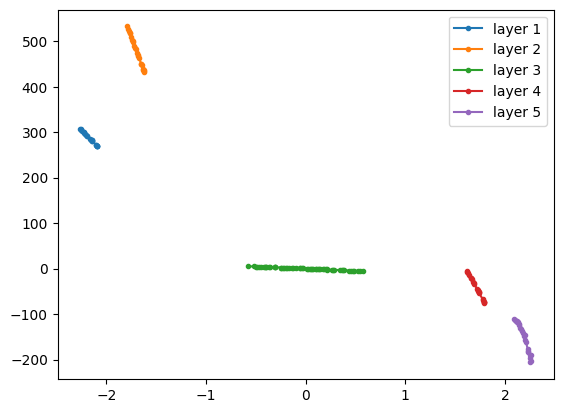

In [32]:
for i,idf in enumerate(rr[-1]["nodes_lines"]):
    zline = idf["z"]
    zline = np.argsort(zline)
    idf = idf.iloc[zline]
    
    plt.plot(idf["z"],idf["P1"],'.-',label="layer "+str(i+1))
plt.legend()

['SY', 'SX', 'Y', 'nucleo', 'Y', 'SX', 'SY']
Time Step:
Time Step:
Time Step:
factor 1.033764404504986


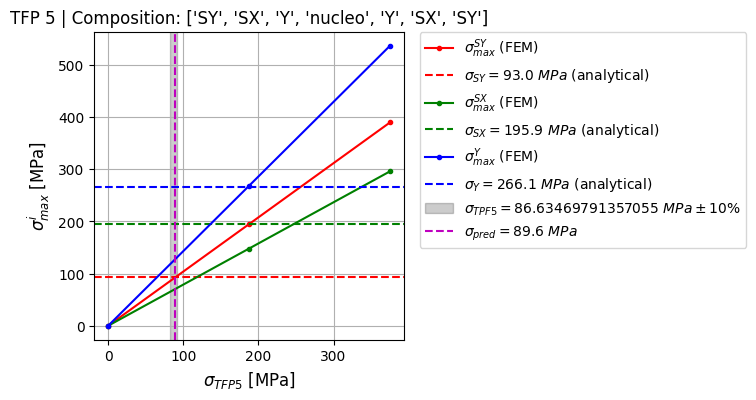

In [33]:
rr,summary = PostProcessing(4)
summaries.append(summary)

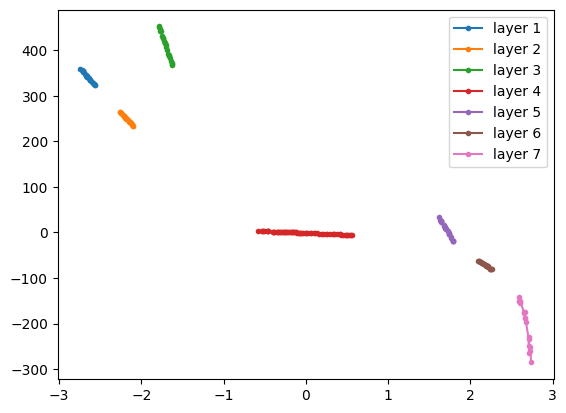

In [34]:
for i,idf in enumerate(rr[-1]["nodes_lines"]):
    zline = idf["z"]
    zline = np.argsort(zline)
    idf = idf.iloc[zline]
    
    plt.plot(idf["z"],idf["P1"],'.-',label="layer "+str(i+1))
plt.legend()

['SY', 'X', 'Y', 'nucleo', 'Y', 'X', 'SY']
Time Step:
Time Step:
Time Step:
factor 1.0228225601601633


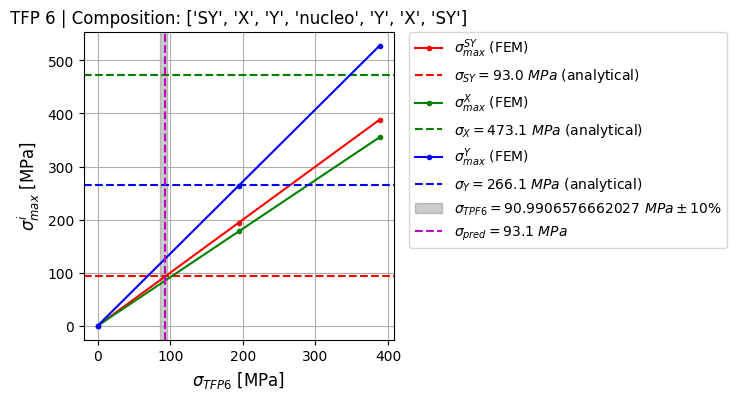

In [35]:
rr,summary = PostProcessing(5)
summaries.append(summary)

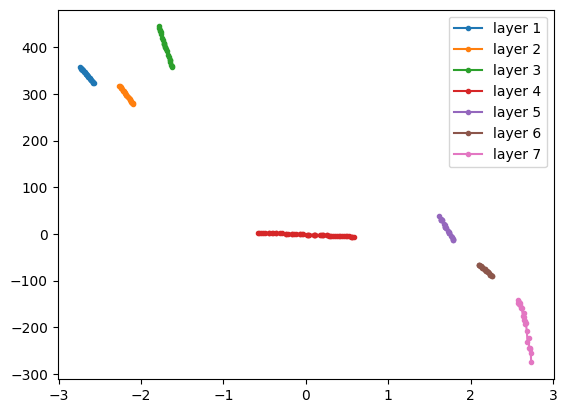

In [36]:
for i,idf in enumerate(rr[-1]["nodes_lines"]):
    zline = idf["z"]
    zline = np.argsort(zline)
    idf = idf.iloc[zline]
    
    plt.plot(idf["z"],idf["P1"],'.-',label="layer "+str(i+1))
plt.legend()

In [37]:
from loadsavejson.savejson import savejson

In [38]:
summaries

[{'layers': ['Y', 'Y', 'nucleo', 'Y', 'Y'],
  'P1': array([[  0.        , 413.21929537, 826.43910964],
         [  0.        , 270.22828043, 540.45658275],
         [  0.        ,   4.8657191 ,   9.73143551],
         [  0.        ,  57.07251716, 114.14503999],
         [  0.        ,  -8.14251133, -16.28521585]]),
  'F3': array([  -0.     , 1775.58884, 3551.17696]),
  'sigma_exp': array([ -0.        , 273.54678529, 547.09345967])},
 {'layers': ['X', 'Y', 'nucleo', 'Y', 'X'],
  'P1': array([[  0.        , 204.38593717, 408.77295544],
         [  0.        , 304.56133531, 609.12195683],
         [  0.        ,   6.59580991,  13.19162147],
         [  0.        ,  31.4104608 ,  62.82092117],
         [  0.        , -24.19988456, -48.40018824]]),
  'F3': array([  -0.     , 1269.74358, 2539.48636]),
  'sigma_exp': array([ -0.        , 195.61638744, 391.23265163])},
 {'layers': ['SX', 'Y', 'nucleo', 'Y', 'SX'],
  'P1': array([[  0.        , 171.1222817 , 342.24493645],
         [  0.       

In [39]:
savejson({"summaries":summaries},"summaries.json")